# Example with torus

In this example we will see how permaviss works in a torus. 
We start by taking a sample of 1300 points from a torus of section radius 1 and radius from center to section center 3. Since this sample is too big, we take a subsample of 150 points by using a minmax method. We store it in `point_cloud`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import scipy.spatial.distance as dist

from permaviss.sample_point_clouds.examples import torus3D, take_sample

X = torus3D(1300,1,3)
point_cloud = take_sample(X,160)

Dist = dist.squareform(dist.pdist(point_cloud))

## Vietoris Rips complex

Now, we compute the Vietoris Rips complex of `point_cloud`. But before we need to import some functions from **permaviss**.

In [3]:
from permaviss.simplicial_complexes.vietoris_rips import vietoris_rips
from permaviss.simplicial_complexes.differentials import complex_differentials


We set the parameter `max_dim` for the maximum dimension and  `max_r` for the maximum radius of the Vietoris-Rips complex produced from `point_cloud`. 

In [4]:
max_r = 1.6
max_dim = 3


C, R = vietoris_rips(Dist, max_r, max_dim)

Also, we plot this using **matplotlib**. First, we introduce a function for plotting general complexes.

In [5]:
def plot_complex(cmpx, axes):
    # plot edges
    for edge in cmpx[1]:
        start_point = point_cloud[edge[0]]
        end_point = point_cloud[edge[1]]
        axes.plot([start_point[0], end_point[0]],
               [start_point[1], end_point[1]],
               [start_point[2], end_point[2]], color="#031926"
               , alpha=0.5*((max_r-Dist[edge[0],edge[1]])/max_r))
  
    # plot vertices
    poly3d = []
    for face in cmpx[2]:
        triangles = []
        for pt in face:
            triangles.append(point_cloud[pt])
        
        poly3d.append(triangles)
        
    axes.add_collection3d(Poly3DCollection(poly3d, linewidths=1, alpha=0.1, color='#468189'))

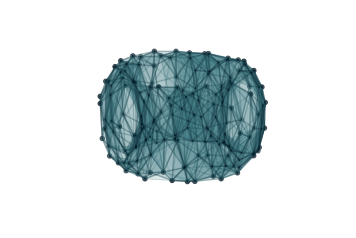

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], color="#031926")
plot_complex(C, ax)
    

ax.grid(False)
ax.set_axis_off()
plt.show()
plt.close(fig)


## Compute ordinary Persistent Homology

Afterwards, we compute the complex differentials using arithmetic mod `p`, a prime number.
Then we get the persistent homology of `point_cloud` with the specified parameters. We store the result in `PerHom`. Additionally, we inspect the second persistent homology group barcodes (notice that these might be empty).

In [7]:
from permaviss.persistence_algebra.PH_classic import persistent_homology

p = 5

Diff = complex_differentials(C, p)
PerHom, _, _ = persistent_homology(Diff, R, max_r, p)
print(PerHom[2].barcode)

[[ 1.55342503  1.6       ]]


## Now, do the same computation using the Mayer-Vietoris spectral sequence

Now we will proceed to compute again persistent homology of `point_cloud` using the Persistence Mayer-Vietoris spectral sequence instead. For this task we take the same parameters `max_r`, `max_dim` and `p` as before. Let us first import **create_MV_ss**. 


In [8]:
from permaviss.spectral_sequence.MV_spectral_seq import create_MV_ss

We set `max_div`, which is the number of divisions along the coordinate with greater range in `point_cloud`, to be 2. This will indicate **create_MV_ss** to cover `point_cloud` by 8 hypercubes. Also, we set the `overlap` between neighbouring regions to be slightly greater than `max_r`. The method **create_MV_ss** prints the ranks of the computed pages and returns a spectral sequence object which we store in `MV_ss`.

In [9]:
max_div = 2
overlap = max_r*1.01

MV_ss = create_MV_ss(point_cloud, max_r, max_dim, max_div, overlap, p)

PAGE: 1
[[  0   0   0   0   0   0   0   0   0]
 [ 99  12   0   0   0   0   0   0   0]
 [219  58   0   0   0   0   0   0   0]]
PAGE: 2
[[  0   0   0   0   0   0   0   0   0]
 [ 87   1   0   0   0   0   0   0   0]
 [161   4   0   0   0   0   0   0   0]]
PAGE: 3
[[  0   0   0   0   0   0   0   0   0]
 [ 87   1   0   0   0   0   0   0   0]
 [161   4   0   0   0   0   0   0   0]]
PAGE: 4
[[  0   0   0   0   0   0   0   0   0]
 [ 87   1   0   0   0   0   0   0   0]
 [161   4   0   0   0   0   0   0   0]]


Now, we compare the computed persistent homology barcodes by both methods. Unless an `AssertError` comes up, this means that the computed barcodes **coincide**. Also, we plot the relevant barcodes. 

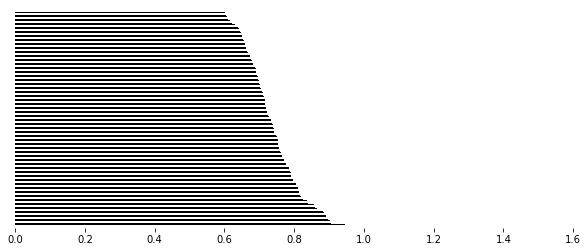

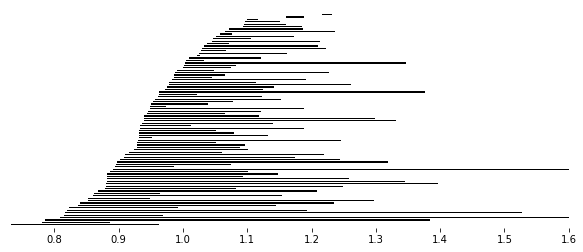

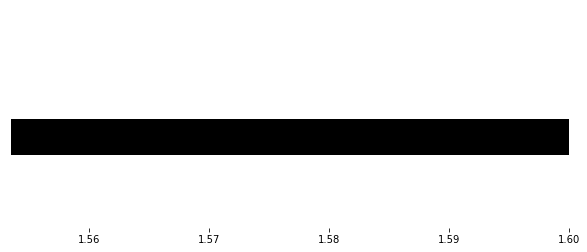

In [10]:
for it, PH in enumerate(MV_ss.persistent_homology):
    # Check that computed barcodes coincide
    assert np.array_equal(PH.barcode, PerHom[it].barcode)
    # Set plotting parameters
    min_r = min(PH.barcode[:,0])
    step = max_r/PH.dim
    width = step / 2.
    fig, ax = plt.subplots(figsize = (10,4))
    ax = plt.axes(frameon=False)
    y_coord = 0
    # Plot barcodes
    for k, b in enumerate(PH.barcode):
        ax.fill([b[0],b[1],b[1],b[0]],[y_coord,y_coord,y_coord+width,y_coord+width],'black',label='H0')
        y_coord += step
  

    # Show figure 
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim([min_r,max_r])
    ax.set_ylim([-step, max_r + step])
    plt.savefig("barcode_r{}.png".format(it))
    plt.show()

## Extended bars

Here we look at the extension information on one dimensional persistence classes. For this we exploit the extra information stored in `MV_ss`. What we do is plot the one dimensional barcodes, highlighting those bars from the ``(0,1)`` position in the infinity page in red. Also, we highlight in blue when these bars are extended by a bar in the ``(1,0)`` position on the infinity page. All the black bars are only comming from classes in the ``(1,0)`` position on the infinity page.  

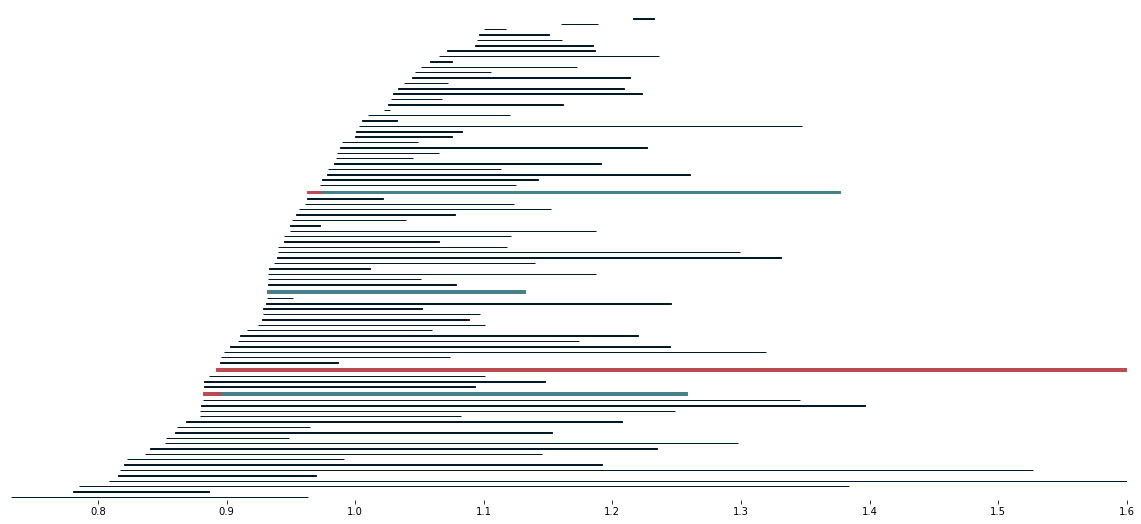

In [11]:
PH = MV_ss.persistent_homology
start_rad = min(PH[1].barcode[:,0])
end_rad = max(PH[1].barcode[:,1])
persistence = end_rad - start_rad
fig, ax = plt.subplots(figsize = (20,9))
ax = plt.axes(frameon=False)
# ax = plt.axes()
step = (persistence /2) / PH[1].dim
width = (step/6.)
y_coord = 0
for b in PH[1].barcode:
    if b[0] not in MV_ss.Hom[2][1][0].barcode[:,0]:
        ax.fill([b[0],b[1],b[1],b[0]],[y_coord,y_coord,y_coord+width,y_coord+width],c="#031926", edgecolor='none')
    else:
        index = np.argmax(b[0] <= MV_ss.Hom[2][1][0].barcode[:,0])
        midpoint = MV_ss.Hom[2][1][0].barcode[index,1]
        ax.fill([b[0], midpoint, midpoint, b[0]],[y_coord,y_coord,y_coord+step,y_coord+step],c="#bc4b51", edgecolor='none')
        ax.fill([midpoint, b[1], b[1], midpoint],[y_coord,y_coord,y_coord+step,y_coord+step],c='#468189', edgecolor='none')
        y_coord = y_coord + step

    y_coord += 2 * step 

# Show figure
ax.axes.get_yaxis().set_visible(False)
ax.set_xlim([start_rad,end_rad])
ax.set_ylim([-step, y_coord + step])
plt.show()

## Extension Representatives

If there was any extension problem. We show a diagram with the solution. In red, representatives of a class
from ``(1,0)``, while in yellow, we plot representatives from a class in ``(0,1)``. A `ValueError` is raised whenever there are no bars to be extended. 

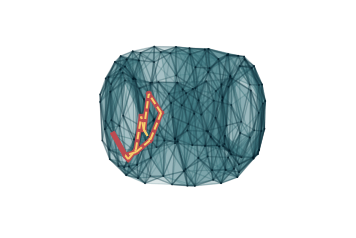

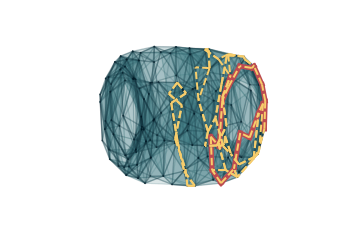

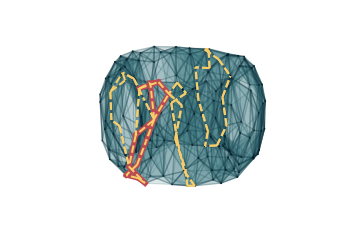

In [12]:


if not np.any(MV_ss.extensions[1][0][1]):
    print("There is no extended bars.")
    raise ValueError

# First, we plot the simplicial complex as we did before
# ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], color="#031926")

extension_indices = [i for i, x in enumerate(np.any(MV_ss.extensions[1][0][1], axis=0)) if x]

for idx_cycle in extension_indices:
    # initialize plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # plot simplicial complex
    plot_complex(C, ax)
    # plot red cycle, that is, a cycle in (1,0)
    cycle = MV_ss.tot_complex_reps[1][0][1][idx_cycle]
    for cover_idx in iter(cycle):
        if len(cycle[cover_idx]) > 0 and np.any(cycle[cover_idx]):
            for l in np.nonzero(cycle[cover_idx])[0]:
                start_pt = MV_ss.nerve_point_cloud[0][cover_idx][
                                MV_ss.subcomplexes[0][cover_idx][1][int(l)][0]
                            ]
                end_pt = MV_ss.nerve_point_cloud[0][cover_idx][
                                MV_ss.subcomplexes[0][cover_idx][1][int(l)][1]
                            ]
                plt.plot([start_pt[0], end_pt[0]],[start_pt[1],end_pt[1]],
                            [start_pt[2], end_pt[2]], c="#bc4b51", 
                         linewidth=5)
        # end if 
    # end for
    # Plot yellow cycles from (0,1) that extend the red cycle
    for idx, cycle in enumerate(MV_ss.tot_complex_reps[0][1][0]):
        # if it extends the cycle in (1,0)
        if MV_ss.extensions[1][0][1][idx, idx_cycle] != 0:
            for cover_idx in iter(cycle):
                if len(cycle[cover_idx]) > 0 and np.any(cycle[cover_idx]):
                    for l in np.nonzero(cycle[cover_idx])[0]:
                        start_pt = MV_ss.nerve_point_cloud[0][cover_idx][
                                        MV_ss.subcomplexes[0][cover_idx][1][int(l)][0]
                                    ]
                        end_pt = MV_ss.nerve_point_cloud[0][cover_idx][
                                        MV_ss.subcomplexes[0][cover_idx][1][int(l)][1]
                                    ]
                        plt.plot([start_pt[0], end_pt[0]],[start_pt[1],end_pt[1]],
                                 [start_pt[2], end_pt[2]], '--', c='#f7cd6c', linewidth=2)
                # end if 
            # end for
        # end if
    # end for
    # Then we show the figure
    ax.grid(False)
    ax.set_axis_off()
    plt.show()
    plt.close(fig)
